# Allstate Corporation

In [25]:
%%html
                                  
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
                                      
<form action="javascript: code_display()">
<input style="color: #0f0c0c; background: LightGray; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>

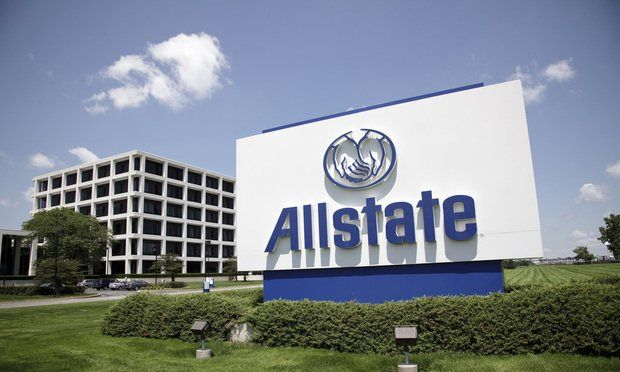

In [32]:
# hide_code
Image("reports/images/allstate.jpg")

## Imports

In [28]:
# data analysis and data wrangling
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Preprocessing
from sklearn.preprocessing import LabelEncoder

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

# metrics
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

# Other
from IPython.display import Image
import gc # clear RAM
import warnings
import time
import os
import subprocess

## Prepare Principal Directory

In [2]:
def exit_current_directory():
    # Actual PATH
    path = os.getcwd()
    print('Current working directory:\n{}\n'.format(path))

    os.chdir('..')
    print('Change directory to:\n{}\n'.format(os.getcwd()))
    
exit_current_directory()

Current working directory:
/home/campos/projetos/challenges/kaggle/allstate-claims-severity/notebooks

Change directory to:
/home/campos/projetos/challenges/kaggle/allstate-claims-severity



### Prepare Environment

In [3]:
# from <package>.<module> import <class>
from src.prepare_environment import *


main()


Requirements this project:

seaborn==0.8.1
numpy==1.14.3
pandas==0.23.0
matplotlib==2.2.2
xgboost==0.82
ipython==7.4.0
scikit_learn==0.20.3
atlas==0.27.0

--------------------------------------------------
Configuration environment:

SO:
Linux
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.2 LTS
Release:	18.04
Codename:	bionic

Pip Version:
pip 10.0.1 from /home/campos/anaconda3/lib/python3.6/site-packages/pip (python 3.6)

Conda Version:
conda 4.6.8

Jupyter Version:
4.4.0

--------------------------------------------------
Structure this project:
.
├── config_environment.txt
├── data
│   ├── sample_submission.csv
│   ├── test.csv
│   └── train.csv
├── LICENSE
├── notebooks
│   └── allstate_corporation-casptone_nanodegreed.ipynb
├── readme.md
├── reports
│   ├── capstone-proposal.md
│   ├── images
│   │   ├── allstate.jpg
│   │   ├── corr_cont_types_13_ate_14.png
│   │   ├── corr_cont_types_1_ate_4.png
│   │   ├── corr_cont_types_5_ate_8.png
│   │   ├── corr_cont_types_all.png

## Format cell

In [38]:
# Guarantees visualization inside the jupyter
%matplotlib inline

# formata os dados de todas as tabelas (ponto flutuante com 2 casas)
pd.options.display.float_format = '{:.2f}'.format

# parametros de config
rc={'savefig.dpi': 75, 
    'figure.autolayout': False, 
    'figure.figsize': [15, 8], 
    'axes.labelsize': 18,
    'axes.titlesize': 18, 
    'font.size': 18, 
    'lines.linewidth': 2.0, 
    'lines.markersize': 8, 
    'legend.fontsize': 16,
    'xtick.labelsize': 16, 
    'ytick.labelsize': 16}

# Print all rows and columns. Dont hide any
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Definition color and map de colors
default_color = '#56B4E9'
colormap = plt.cm.cool

# Single colour palettes for good and bad outcomes
good_palette = ['#44cc44']
bad_palette = ['#cc4444']
# Colour palette for gender - traditional light pink (female), light blue (male)
gender_palette = ['#B0C4DE','#FFB6C1']
# Colour palette for ticket class - gold (first), silver (second), bronze (third)
class_palette = ['#FFD700','#C0C0C0','#CD7F32']

# Supress unnecessary warnings so that presentation looks clean
warnings.filterwarnings('ignore')

# graph style
sns.set(style='dark',rc=rc)

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load dataset

In [57]:
%%time

# load data in dataset
df_train = pd.read_csv("data/train.csv", 
                       encoding='utf-8')
df_test = pd.read_csv("data/test.csv", 
                      encoding='utf-8')

CPU times: user 4.02 s, sys: 95.7 ms, total: 4.12 s
Wall time: 4.12 s


### Merge Data Sets

Merged the training and test sets temporarily.

In [58]:
# Merge datasets
frames = [df_train, df_test]
data = pd.concat(frames)
print("The merge datasets train and test:\n{} rows\n{} columns"
      .format(data.shape[0],
              data.shape[1]))

The merge datasets train and test:
313864 rows
132 columns


## Data analysis 

#### Datasets
The dataset contains 2 .csv files with information needed to make a forecast. They are::<br/>
1. Variables in train.csv and test.csv: 
 - **id:** the id of a couple of questions from the training set
 - **cat1 to cat116:** category variables (the range of values is not provided, nor the column names).
 - **cont1 to cont14:** continuous variables (the range of values is not provided nor the names of the columns).
 - **loss:** the amount that the company has to pay for a particular claim. This is the target variable.
 
 
 NOTE: In test.csv, the loss is not present, since we will predict this.

In [41]:
# Size and types of the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313864 entries, 0 to 125545
Columns: 132 entries, cat1 to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 318.5+ MB


In [42]:
print("Dataframe:\n{} rows\n{} columns"
      .format(data.shape[0],
              data.shape[1]))

Dataframe:
313864 rows
132 columns


### Data Type
Within _data_ there are 3 types of data: <br/>
- float64(15) = continuos_feature + loss
- int64(1) = id
- object(116) = categorical_feature

In [9]:
data.head()

,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat11,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat3,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat4,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat5,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat6,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat7,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat8,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat9,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cont1,cont10,cont11,cont12,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,id,loss
0,A,A,B,G,A,A,I,E,G,J,G,BU,B,BC,C,AS,S,A,O,LB,A,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,A,D,D,B,D,C,B,D,B,A,A,B,A,A,A,D,B,C,E,A,C,T,0.73,0.84,0.57,0.59,0.82,0.71,0.25,0.19,0.79,0.31,0.72,0.34,0.30,0.67,1,2213.18
1,A,B,L,F,A,A,E,E,I,K,K,BI,A,CQ,A,AV,BM,A,O,DP,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,D,D,A,B,C,B,D,B,A,A,B,A,A,A,D,D,C,E,E,D,T,0.33,0.44,0.34,0.37,0.61,0.30,0.74,0.59,0.61,0.89,0.44,0.44,0.60,0.35,2,1283.60
2,A,B,L,O,A,B,E,F,H,F,A,AB,B,DK,A,C,AF,A,I,GK,B,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,B,D,B,D,C,B,B,B,A,A,B,A,A,A,D,D,C,E,E,A,D,0.26,0.32,0.38,0.37,0.20,0.77,0.36,0.48,0.24,0.40,0.29,0.32,0.27,0.26,5,3005.09
3,B,A,I,D,A,A,E,E,I,K,K,BI,A,CS,C,N,AE,A,O,DJ,A,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,A,D,D,D,B,C,B,D,B,A,A,B,A,A,A,D,D,C,E,E,D,T,0.32,0.44,0.33,0.32,0.61,0.60,0.56,0.53,0.37,0.42,0.44,0.39,0.32,0.32,10,939.85
4,A,B,F,J,A,A,D,E,K,G,B,H,A,C,C,Y,BM,A,K,CK,B,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,A,B,D,B,B,C,B,B,C,A,A,B,A,B,H,D,B,D,E,E,A,P,0.27,0.21,0.20,0.20,0.25,0.43,0.16,0.53,0.47,0.70,0.18,0.25,0.25,0.22,11,2763.85


In [10]:
# Types data in collumns
print(data.dtypes)

cat1       object
cat10      object
cat100     object
cat101     object
cat102     object
cat103     object
cat104     object
cat105     object
cat106     object
cat107     object
cat108     object
cat109     object
cat11      object
cat110     object
cat111     object
cat112     object
cat113     object
cat114     object
cat115     object
cat116     object
cat12      object
cat13      object
cat14      object
cat15      object
cat16      object
cat17      object
cat18      object
cat19      object
cat2       object
cat20      object
cat21      object
cat22      object
cat23      object
cat24      object
cat25      object
cat26      object
cat27      object
cat28      object
cat29      object
cat3       object
cat30      object
cat31      object
cat32      object
cat33      object
cat34      object
cat35      object
cat36      object
cat37      object
cat38      object
cat39      object
cat4       object
cat40      object
cat41      object
cat42      object
cat43      object
cat44     

In [11]:
# describing statistics of categorical variables
data.describe(include = ['object'])

,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat11,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat3,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat4,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat5,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat6,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat7,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat8,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat9,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99
count,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864,313864
unique,2,2,15,19,9,14,17,20,18,20,11,85,2,134,17,51,63,19,23,349,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,4,4,4,2,4,4,4,4,4,4,4,4,4,9,2,7,8,9,5,7,5,9,7,5,17
top,A,A,F,A,A,A,E,E,G,F,B,BI,A,CL,A,E,BM,A,K,HK,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,D,D,B,B,C,B,B,B,A,A,A,A,A,A,D,D,C,E,C,A,P
freq,235646,267157,71817,177924,295386,206019,71557,127477,78180,78863,108731,255052,280656,42097,214421,42109,43756,219707,73027,35076,266602,281455,309995,313807,303105,311675,312233,310886,177924,313548,313196,313794,262717,303407,283374,295196,280489,301689,307686,296745,308007,305041,311830,312275,312918,313522,260348,276241,282097,305563,214421,300200,302017,310966,306921,287701,306638,312408,312672,313415,298622,206019,229499,311832,299266,288337,306339,313622,313571,308856,313472,313358,219707,313161,312620,313798,313740,313795,310077,299912,312738,313613,313362,306290,313821,297833,197808,256870,307786,257135,302213,312479,310851,254936,295386,229344,257299,245540,235643,258138,309968,172499,278298,281353,306290,188631,296745,184815,207742,250268,202549,146367,290522,129940,175292,132100


In [12]:
# describing statistics of continuos variables
data.describe()

,cont1,cont10,cont11,cont12,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,id,loss
count,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,313864.00,188318.00
mean,0.49,0.50,0.49,0.49,0.49,0.50,0.51,0.50,0.49,0.49,0.49,0.49,0.49,0.49,294108.45,3037.34
std,0.19,0.19,0.21,0.21,0.21,0.22,0.21,0.20,0.21,0.21,0.21,0.18,0.20,0.18,169641.13,2904.09
min,0.00,0.00,0.04,0.04,0.00,0.18,0.00,0.00,0.18,0.28,0.01,0.07,0.24,0.00,1.00,0.67
25%,0.35,0.36,0.31,0.31,0.32,0.29,0.36,0.34,0.33,0.28,0.34,0.35,0.32,0.36,147263.75,1204.46
50%,0.48,0.46,0.46,0.46,0.36,0.41,0.56,0.53,0.45,0.42,0.44,0.44,0.44,0.44,294432.50,2115.57
75%,0.63,0.62,0.68,0.68,0.69,0.72,0.68,0.63,0.65,0.64,0.66,0.59,0.62,0.57,441176.50,3864.05
max,0.98,0.99,1.00,1.00,0.99,0.84,0.86,0.94,0.96,0.98,1.00,1.00,0.98,1.00,587634.00,121012.25


In [13]:
data.columns

Index(['cat1', 'cat10', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104',
       'cat105', 'cat106', 'cat107',
       ...
       'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9',
       'id', 'loss'],
      dtype='object', length=132)

## Data Cleanning

- Check index
- Check missing values
- Check duplicated values
- Check outliers
- Sepearte the categorical and continous features

#### Index

In [14]:
data.tail()

,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat11,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat3,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat4,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat5,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat6,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat7,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat8,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat9,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cont1,cont10,cont11,cont12,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,id,loss
125541,A,A,L,A,A,A,F,F,G,F,D,BI,A,CL,C,AI,H,A,K,GS,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,A,C,B,B,B,C,B,B,B,A,A,A,A,A,A,D,D,D,E,A,A,P,0.46,0.41,0.55,0.54,0.30,0.35,0.25,0.65,0.28,0.28,0.44,0.82,0.39,0.49,587617,nan
125542,A,A,F,A,B,D,E,F,I,J,K,BI,A,DM,A,AV,BJ,J,O,DP,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,B,A,D,B,B,B,D,D,B,B,C,B,D,B,A,A,A,A,B,H,D,D,C,E,E,D,T,0.30,0.27,0.32,0.35,0.49,0.29,0.49,0.55,0.27,0.67,0.35,0.42,0.48,0.26,587621,nan
125543,B,B,F,F,A,B,K,H,F,H,G,BI,A,BP,A,E,BM,A,P,LY,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,D,D,B,B,C,B,D,B,D,A,B,A,B,H,D,D,C,E,A,C,T,0.90,0.84,0.93,0.93,0.85,0.81,0.56,0.48,0.59,0.79,0.81,0.51,0.72,0.94,587627,nan
125544,A,A,J,A,B,A,E,E,J,K,K,K,A,EB,A,K,AE,E,O,DJ,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,B,D,D,B,A,C,B,D,B,A,A,A,A,A,A,D,B,C,E,E,D,T,0.33,0.37,0.31,0.30,0.61,0.36,0.36,0.48,0.37,0.30,0.37,0.39,0.32,0.32,587629,nan
125545,A,A,H,G,A,A,D,E,J,G,B,AB,B,EL,A,AF,AF,A,L,CR,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,A,B,D,B,D,C,B,B,D,A,A,B,A,A,A,D,D,D,E,E,A,P,0.31,0.25,0.25,0.24,0.29,0.22,0.30,0.55,0.21,0.41,0.22,0.24,0.25,0.31,587634,nan


Ok, follow in order.

#### Missing Values

In [15]:
# return TRUE if collumn contains values missing

missing = data.isnull().any()
print(missing)

cat1      False
cat10     False
cat100    False
cat101    False
cat102    False
cat103    False
cat104    False
cat105    False
cat106    False
cat107    False
cat108    False
cat109    False
cat11     False
cat110    False
cat111    False
cat112    False
cat113    False
cat114    False
cat115    False
cat116    False
cat12     False
cat13     False
cat14     False
cat15     False
cat16     False
cat17     False
cat18     False
cat19     False
cat2      False
cat20     False
cat21     False
cat22     False
cat23     False
cat24     False
cat25     False
cat26     False
cat27     False
cat28     False
cat29     False
cat3      False
cat30     False
cat31     False
cat32     False
cat33     False
cat34     False
cat35     False
cat36     False
cat37     False
cat38     False
cat39     False
cat4      False
cat40     False
cat41     False
cat42     False
cat43     False
cat44     False
cat45     False
cat46     False
cat47     False
cat48     False
cat49     False
cat5      False
cat50   

In [47]:
# Check each columns by values missing

missing = data.isnull().any()

for i in missing:
    if i == True:
        print ("Column contains values missing !")

print("There are now {} missing values in the loss column".format(data['loss'].isnull().sum()))

Column contains values missing !
There are now 125546 missing values in the loss column


#### Duplicated Values

In [48]:
# Check if contains duplicated data

# Mark duplicates as ``True`` if enough row equal
# Except for the first occurrence.
duplicated = data.duplicated().sum()

print("Size dataframe = ", data.shape)
print("There are now {} duplicated values in dataframe.".format(duplicated))

Size dataframe =  (313864, 132)
There are now 0 duplicated values in dataframe.


#### Outliers

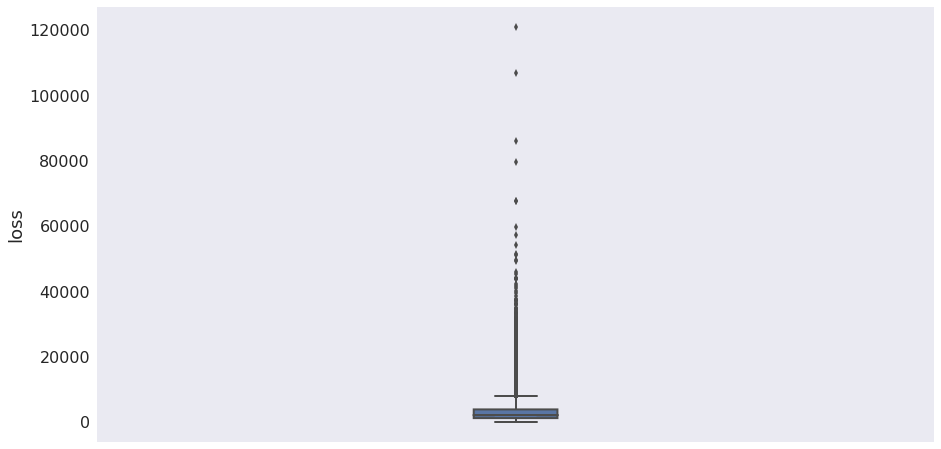

In [49]:
sns.boxplot(y=data['loss'], 
            width=0.1,
            notch=True)

In [50]:
def calcule_outlier_by_column(df_in, col_name):
    """
    Calculate quantile Q1 and Q3
    Calculate fence low and high
    Count outliers
    Add new collumn in dataframe with row with cointains outliers
    """    
    quantile_1 = df_in[col_name].quantile(q=0.25, interpolation='linear')
    quantile_3 = df_in[col_name].quantile(q=0.75, interpolation='linear')
    iqr = quantile_3-quantile_1 #Interquartile range
    print('IQR = ', iqr)
    
    fence_low  = quantile_1-1.5*iqr
    fence_high = quantile_3+1.5*iqr
    
    size = df_in.shape
    print('size dataframe = ',size)
    
    outlier_less_q1 = df_in[(df_in[col_name] < fence_low)].count()
    outlier_more_q3 = df_in[(df_in[col_name] > fence_high)].count()
    
    # Create new column
    mask = (df_in[col_name] < (quantile_1 - 1.5 * iqr)) | \
            (df_in[col_name] > (quantile_3 + 1.5 * iqr))
    df_in['outlier'] = mask.values
    
    # Convert bool values in integer
    df_in['outlier'] = df_in['outlier'].astype('uint8')
    
    
    return print('\nOutlier < quantile_1:\n{}\n\nOutlier > quantile_3:\n{}' \
                 .format(outlier_less_q1, outlier_more_q3))

In [51]:
calcule_outlier_by_column(data, 'loss')

IQR =  2659.5850000000005
size dataframe =  (313864, 132)

Outlier < quantile_1:
cat1      0
cat10     0
cat100    0
cat101    0
cat102    0
cat103    0
cat104    0
cat105    0
cat106    0
cat107    0
cat108    0
cat109    0
cat11     0
cat110    0
cat111    0
cat112    0
cat113    0
cat114    0
cat115    0
cat116    0
cat12     0
cat13     0
cat14     0
cat15     0
cat16     0
cat17     0
cat18     0
cat19     0
cat2      0
cat20     0
cat21     0
cat22     0
cat23     0
cat24     0
cat25     0
cat26     0
cat27     0
cat28     0
cat29     0
cat3      0
cat30     0
cat31     0
cat32     0
cat33     0
cat34     0
cat35     0
cat36     0
cat37     0
cat38     0
cat39     0
cat4      0
cat40     0
cat41     0
cat42     0
cat43     0
cat44     0
cat45     0
cat46     0
cat47     0
cat48     0
cat49     0
cat5      0
cat50     0
cat51     0
cat52     0
cat53     0
cat54     0
cat55     0
cat56     0
cat57     0
cat58     0
cat59     0
cat6      0
cat60     0
cat61     0
cat62     0
cat63  

In [52]:
data.shape

(313864, 133)

In [53]:
data.head(15)

,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat11,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat3,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat4,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat5,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat6,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat7,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat8,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat9,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cont1,cont10,cont11,cont12,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,id,loss,outlier
0,A,A,B,G,A,A,I,E,G,J,G,BU,B,BC,C,AS,S,A,O,LB,A,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,D,B,B,A,D,D,B,D,C,B,D,B,A,A,B,A,A,A,D,B,C,E,A,C,T,0.73,0.84,0.57,0.59,0.82,0.71,0.25,0.19,0.79,0.31,0.72,0.34,0.30,0.67,1,2213.18,0
1,A,B,L,F,A,A,E,E,I,K,K,BI,A,CQ,A,AV,BM,A,O,DP,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,D,D,A,B,C,B,D,B,A,A,B,A,A,A,D,D,C,E,E,D,T,0.33,0.44,0.34,0.37,0.61,0.30,0.74,0.59,0.61,0.89,0.44,0.44,0.60,0.35,2,1283.60,0
2,A,B,L,O,A,B,E,F,H,F,A,AB,B,DK,A,C,AF,A,I,GK,B,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,B,D,B,D,C,B,B,B,A,A,B,A,A,A,D,D,C,E,E,A,D,0.26,0.32,0.38,0.37,0.20,0.77,0.36,0.48,0.24,0.40,0.29,0.32,0.27,0.26,5,3005.09,0
3,B,A,I,D,A,A,E,E,I,K,K,BI,A,CS,C,N,AE,A,O,DJ,A,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,D,B,B,A,D,D,D,B,C,B,D,B,A,A,B,A,A,A,D,D,C,E,E,D,T,0.32,0.44,0.33,0.32,0.61,0.60,0.56,0.53,0.37,0.42,0.44,0.39,0.32,0.32,10,939.85,0
4,A,B,F,J,A,A,D,E,K,G,B,H,A,C,C,Y,BM,A,K,CK,B,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,A,B,D,B,B,C,B,B,C,A,A,B,A,B,H,D,B,D,E,E,A,P,0.27,0.21,0.20,0.20,0.25,0.43,0.16,0.53,0.47,0.70,0.18,0.25,0.25,0.22,11,2763.85,0
5,A,A,J,D,A,A,E,E,H,F,B,BI,A,CS,A,AS,AE,A,K,DJ,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,A,B,D,B,B,C,B,B,B,A,A,B,A,A,A,D,D,D,E,C,A,P,0.55,0.51,0.37,0.36,0.35,0.73,0.68,0.63,0.37,0.30,0.36,0.40,0.27,0.46,13,5142.87,0
6,A,A,J,A,A,C,E,E,H,F,B,BI,A,DK,A,J,AF,A,K,DJ,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,B,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,D,D,B,D,C,B,B,B,A,A,A,A,A,A,D,D,D,E,C,A,P,0.47,0.47,0.33,0.35,0.34,0.38,0.74,0.61,0.19,0.30,0.38,0.36,0.25,0.40,14,1132.22,0
7,A,A,H,C,A,A,K,F,F,I,G,BI,A,EB,G,AH,Y,A,P,LO,A,A,A,A,A,A,A,A,B,A,A,A,B,A,A,A,A,B,A,A,A,A,B,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,D,A,B,D,A,B,C,B,D,C,D,A,B,A,A,A,C,B,C,E,A,C,T,0.83,0.80,0.64,0.79,0.86,0.24,0.49,0.26,0.62,0.47,0.87,0.58,0.90,0.85,20,3585.75,0
8,A,B,C,Q,A,C,H,F,G,M,K,BI,B,BC,C,K,AX,A,Q,IE,B,B,A,A,B,A,A,A,B,A,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,B,A,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,D,B,D,A,B,B,B,B,C,B,D,D,A,A,B,B,A,A,D,C,C,E,C,D,T,0.33,0.51,0.68,0.67,0.76,0.36,0.56,0.44,0.47,0.28,0.63,0.38,0.61,0.38,23,10280.20,1
9,A,A,F,D,A,F,K,H,G,J,G,BU,A,DW,A,U,S,J,O,LY,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,A,B,A,B,A,A,A,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,D,B,B,A,B,B,B,B,C,B,D,C,D,A,B,A,B,H,D,B,C,E,A,C,T,0.73,0.84,0.86,0.88,0.82,0.29,0.36,0.36,0.80,0.31,0.71,0.47,0.30,0.

Get 11554 outliers by column. 

In this context, outliers are important to analysis, so them ar not removed.

## Data Preprocessing
-  Log _loss_ transform
- Convert categorical string values to numeric values

### Log _loss_ transform
- Log transform help data to make gaussian distribuition

In [54]:
log_loss = np.log(data['loss'])

default_loss = data['loss']

### Convert categorical string values to numeric values

There are 116 categories with non alphanumeric values, most of the machine learning algorithms doesn't work with alpha numeric values. So, lets convert it into numeric values

In [61]:
# Separete datas in list with feature loss

continuous_types = []
categorical_types = []

for i in data.columns:
    if df_train[i].dtype == 'float':
        continuous_types.append(i)
    else:
        categorical_types.append(i)
categorical_types.remove('id')

print("Continuos Features: \n{} \n".format(continuous_types))
print("Categorical Features: \n{}\n".format(categorical_types))

Continuos Features: 
['cont1', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'loss'] 

Categorical Features: 
['cat1', 'cat10', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat11', 'cat110', 'cat111', 'cat112', 'cat113', 'cat114', 'cat115', 'cat116', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat2', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat3', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat4', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat5', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat6', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat7', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'c

In [63]:
# data df
# convert the categorical variables into numbers

data_copy = data.copy().loc[:, categorical_types]

for cat_feat in data_copy.columns:
    data_copy[cat_feat] = pd.factorize(data_copy[cat_feat], sort=True)[0]

In [64]:
data_copy.head()

,cat1,cat10,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat11,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat2,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat3,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat4,cat40,cat41,cat42,cat43,cat44,cat45,cat46,cat47,cat48,cat49,cat5,cat50,cat51,cat52,cat53,cat54,cat55,cat56,cat57,cat58,cat59,cat6,cat60,cat61,cat62,cat63,cat64,cat65,cat66,cat67,cat68,cat69,cat7,cat70,cat71,cat72,cat73,cat74,cat75,cat76,cat77,cat78,cat79,cat8,cat80,cat81,cat82,cat83,cat84,cat85,cat86,cat87,cat88,cat89,cat9,cat90,cat91,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99
0,0,0,1,6,0,0,8,4,6,9,6,46,1,28,2,19,57,0,14,288,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,3,1,1,0,3,3,1,3,2,1,3,1,0,0,1,0,0,0,3,1,2,4,0,2,15
1,0,1,11,5,0,0,4,4,8,10,10,34,0,67,0,22,39,0,14,94,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,0,3,3,0,1,2,1,3,1,0,0,1,0,0,0,3,3,2,4,4,3,15
2,0,1,11,14,0,1,4,5,7,5,0,2,1,87,0,28,6,0,8,167,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,1,0,1,3,1,3,2,1,1,1,0,0,1,0,0,0,3,3,2,4,4,0,1
3,1,0,8,3,0,0,4,4,8,10,10,34,0,69,2,39,5,0,14,88,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,1,1,0,3,3,3,1,2,1,3,1,0,0,1,0,0,0,3,3,2,4,4,3,15
4,0,1,5,9,0,0,3,4,10,6,1,67,0,51,2,50,39,0,10,63,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,3,0,1,3,1,1,2,1,1,2,0,0,1,0,1,7,3,1,3,4,4,0,12


## Data Visualization

- Loss Variable
- Continuous feature
 - Visualize data continuos
 - Correlation data continuos
 - Matrix correlation: continuous features
- Categorical feature
 - Transform categorical feature
 - Visualize data categorical
 - Matrix correlation: categorical features

### _Loss_ target

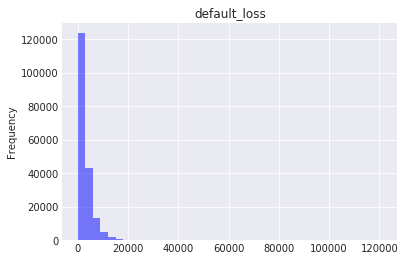

In [71]:
# Plot showing loss distribution
plt.figure()
default_loss_img = default_loss.plot.hist(alpha=0.5, color = 'blue', bins = 40)
plt.title("default_loss")
plt.show()

In [72]:
# save image
fig = default_loss_img.get_figure()
fig.savefig("images/default_loss.png")
print(f"Output (default_loss) saved.")

Output (default_loss) saved.


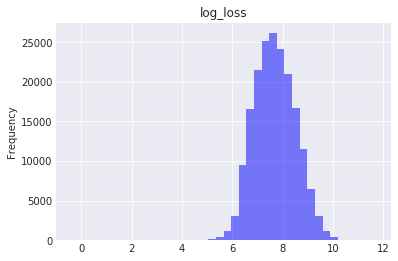

In [73]:
# Plot showing loss distribution
plt.figure()
log_loss_img = log_loss.plot.hist(alpha=0.5, color = 'blue', bins = 40)
plt.title("log_loss")
plt.show()

In [74]:
# save image
fig = log_loss_img.get_figure()
fig.savefig("reports/images/log_loss.png")
print(f"Output (log_loss) saved.")

Output (log_loss) saved.


It`s possible see that it is skewed to the left.

#### PCA (Kernel Density Estimate)

In [100]:
### Preparing data to KDE

lable = df_train['loss'].values
dataset_visual = df_train.drop(['loss'], axis = 1)
dataset_visual = df_train[continuous_types].values
dataset_visual = StandardScaler().fit_transform(dataset_visual)

# import some data to play
X = dataset_visual
y = data['loss']

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

pca = PCA(n_components=3)
principalComponents  = pca.fit_transform(X)

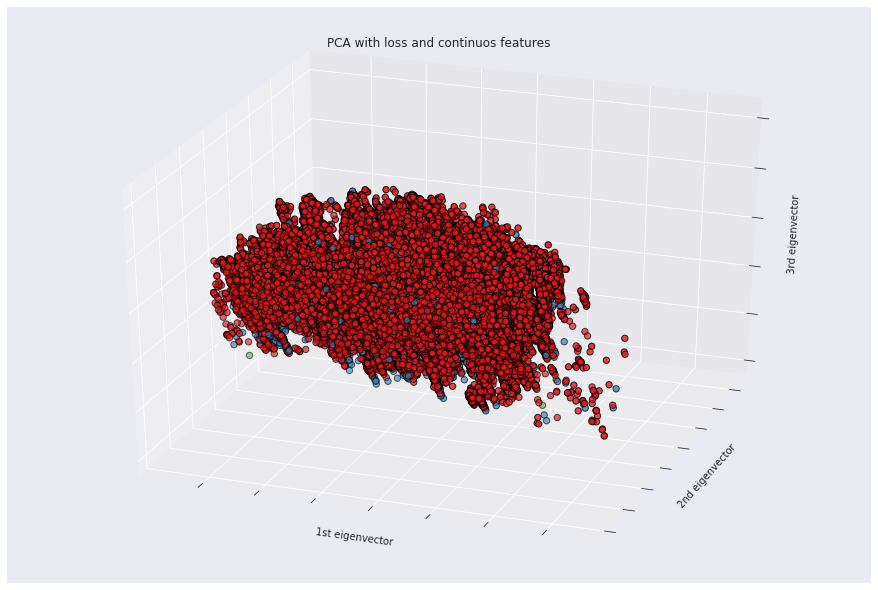

In [107]:
# Plotting a Kernel Density Estimate (KDE) with three PCA dimensions
fig3 = plt.figure(2, figsize=(12, 8))
ax2 = Axes3D(fig3, elev=-150, azim=70)
pca_img = ax2.scatter(principalComponents[:, 0],
                      principalComponents[:, 1], 
                      principalComponents[:, 2],
                      c=lable, 
                      cmap=plt.cm.Set1,
                      edgecolor='k', s=40)

ax2.set_title("PCA with loss and continuos features")
ax2.set_xlabel("1st eigenvector")
ax2.w_xaxis.set_ticklabels([])
ax2.set_ylabel("2nd eigenvector")
ax2.w_yaxis.set_ticklabels([])
ax2.set_zlabel("3rd eigenvector")
ax2.w_zaxis.set_ticklabels([])

plt.show()

In [53]:
# PCA data variance
print(pca2.explained_variance_ratio_)

[0.05972385 0.04735898 0.04297918]


It is seen that the data are well grouped and presented in a PCA of 3 dimensions for each one of its components the variance of 5.97%, 4.73% and 4.29%, being a total of 14.99%.

In [108]:
# save image PCA
fig = pca_img.get_figure()
fig.savefig("reports/images/pca.png")
print(f"Output (pca) saved.")

Output (pca) saved.


#### Data  Continuos Distribuition

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1b354c0b8>,
      dtype=object)

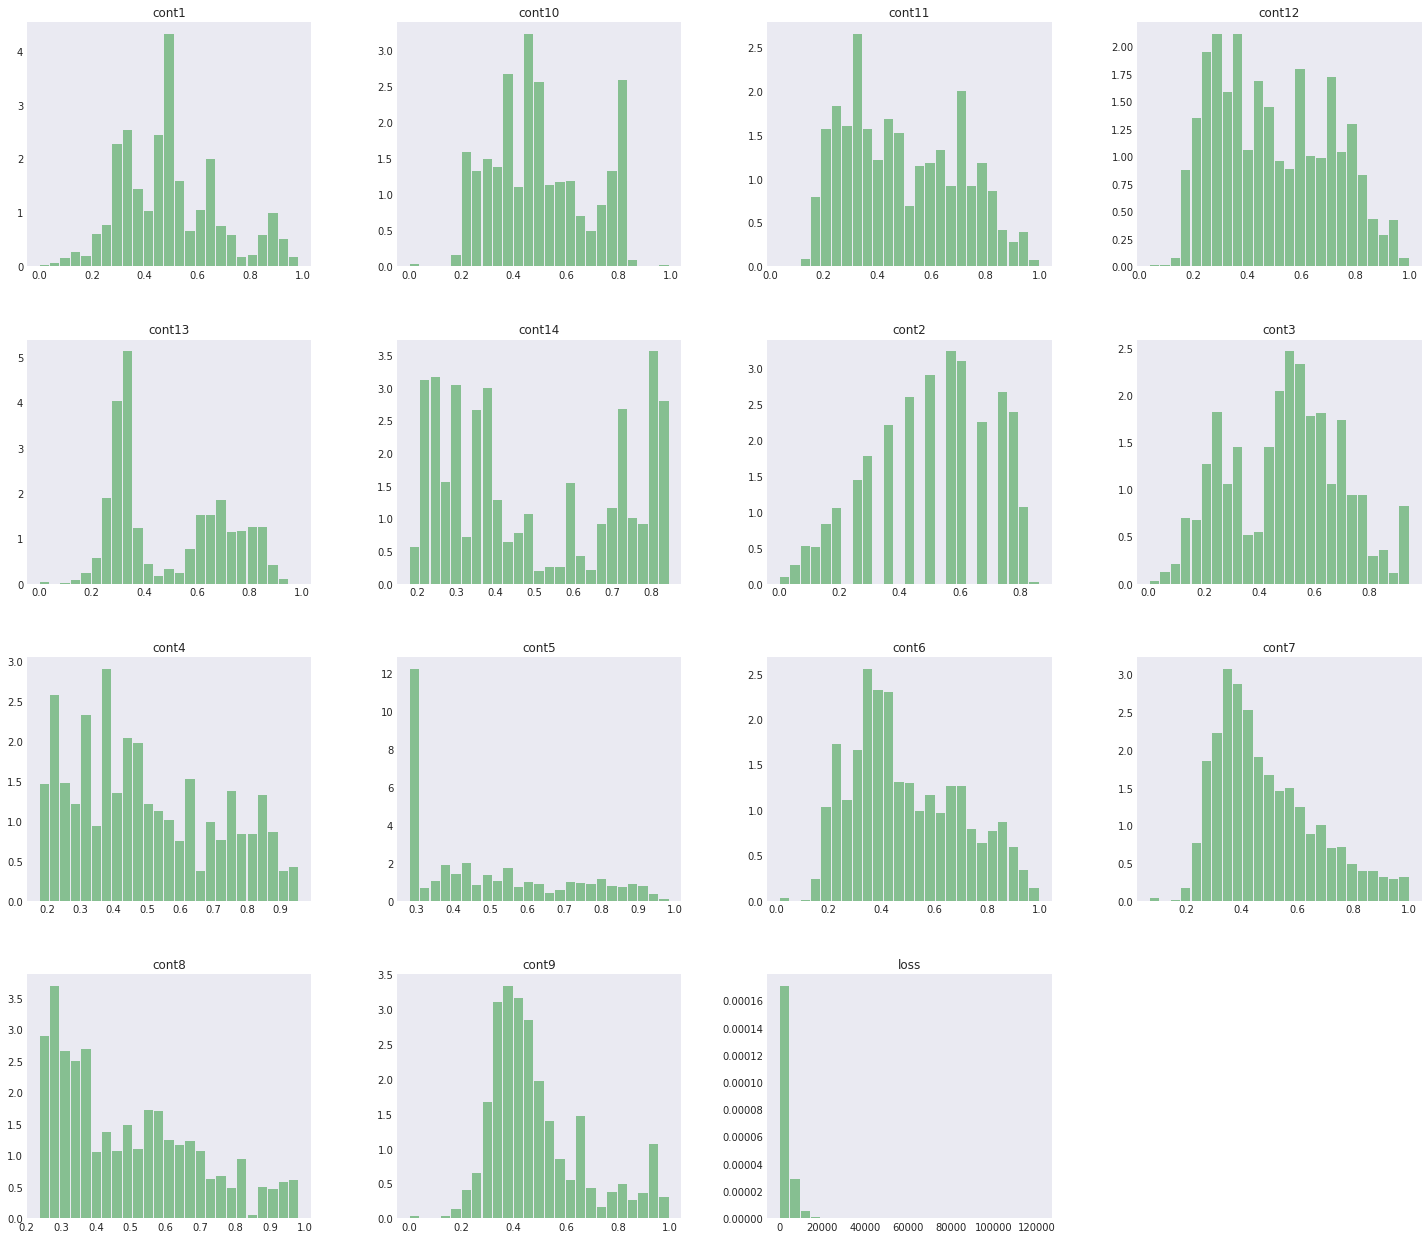

In [143]:
# the histogram of the data
data[continuous_types].hist(figsize=[25,22], 
                            density=True, 
                            bins=25, 
                            grid=False, 
                            color='#86bf91', 
                            zorder=2, 
                            rwidth=0.9)

#### Correlations

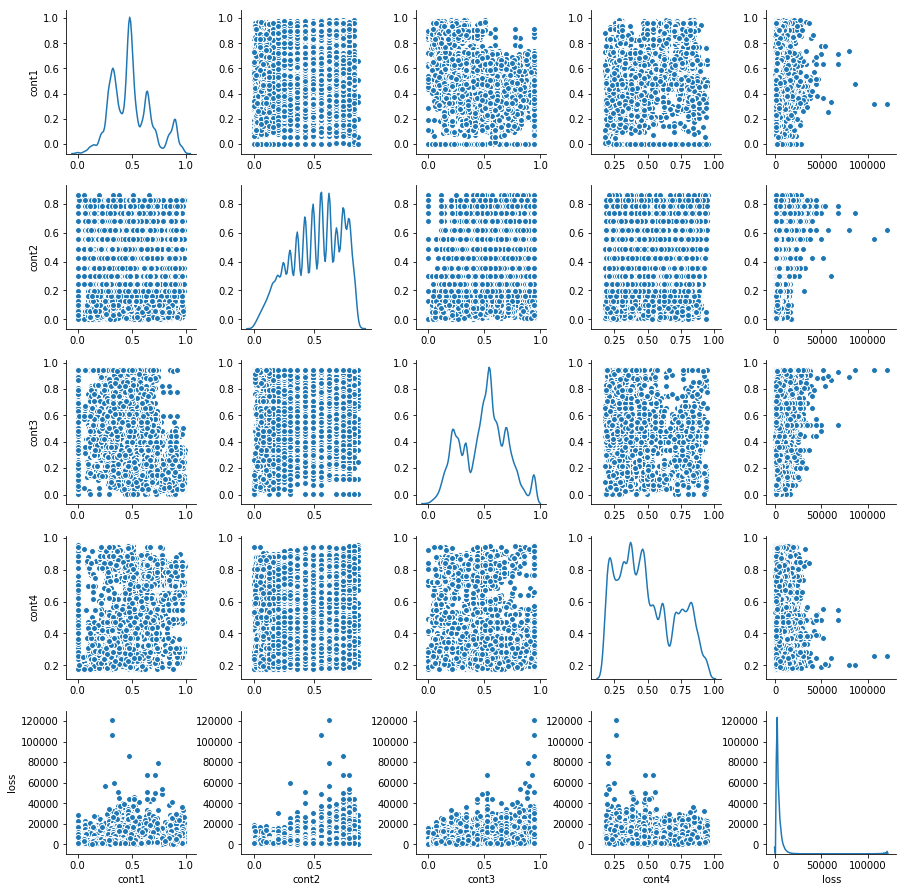

In [21]:
corr_cont_types_1_ate_4 = sns.pairplot(
                            df_train[continuous_types],
                            vars=['cont1','cont2','cont3','cont4','loss'],
                            kind = 'scatter',
                            diag_kind='kde')
print(corr_cont_types_1_ate_4)

In [27]:
# save image
fig = corr_cont_types_1_ate_4.fig.savefig("reports/images/corr_cont_types_1_ate_4.png")
print(f"Output (corr_cont_types_1_ate_4) saved.")

Output (corr_cont_types_1_ate_4) saved.


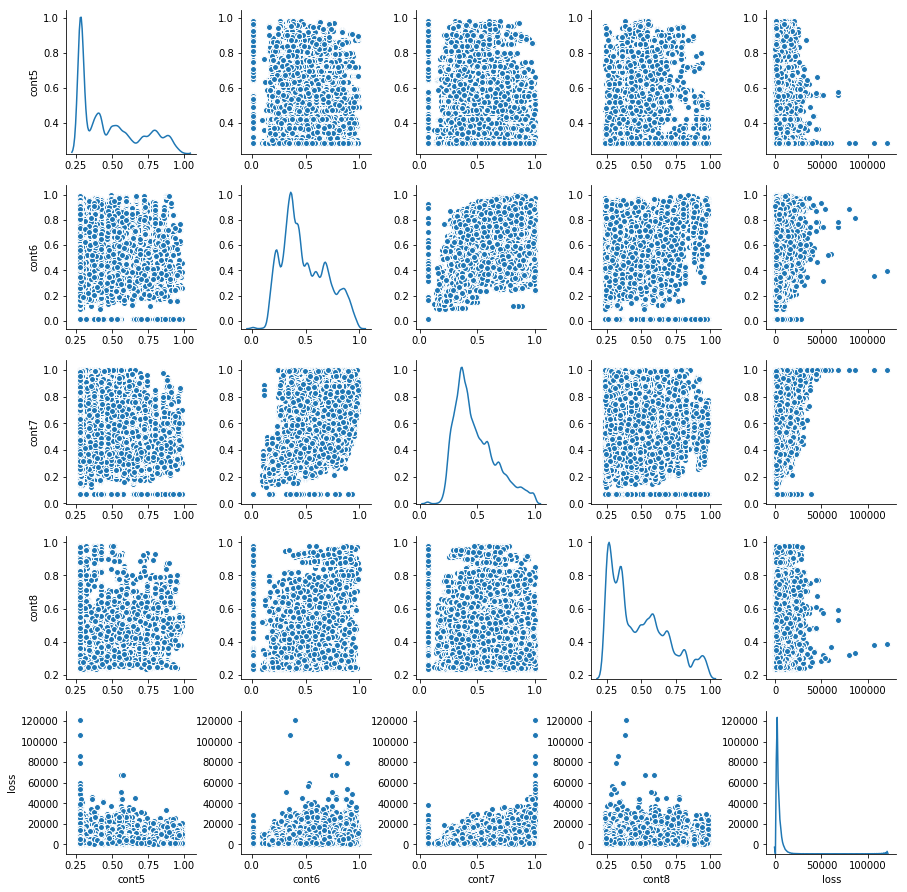

In [28]:
corr_cont_types_5_ate_8 = sns.pairplot(
    df_train[continuous_types],
    vars=['cont5','cont6','cont7','cont8','loss'],
    kind = 'scatter',
    diag_kind='kde')
print(corr_cont_types_5_ate_8)

In [ ]:
msno.dendrogram(df_train[continuous_types], figsize=(12,5))

In [29]:
# save image
fig = corr_cont_types_5_ate_8.savefig("reports/images/corr_cont_types_5_ate_8.png")
print(f"Output (corr_cont_types_5_ate_8) saved.")

Output (corr_cont_types_5_ate_8) saved.


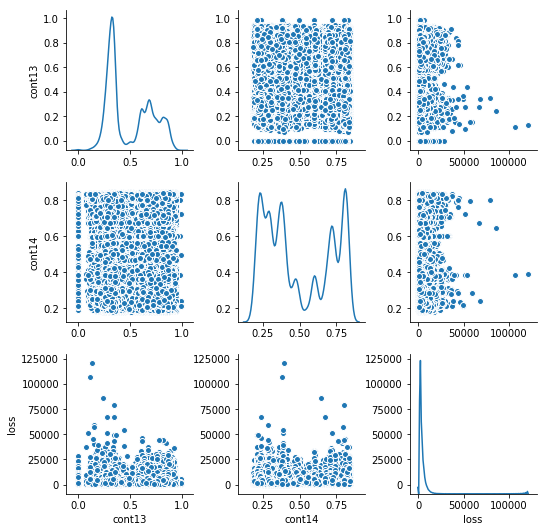

In [30]:
corr_cont_types_13_ate_14 = sns.pairplot(
    df_train[continuous_types],
    vars=['cont13','cont14','loss'],
    kind = 'scatter',
    diag_kind='kde')
print(corr_cont_types_13_ate_14)

In [31]:
# save image
fig = corr_cont_types_13_ate_14.savefig("reports/images/corr_cont_types_13_ate_14.png")
print(f"Output (corr_cont_types_13_ate_14) saved.")

Output (corr_cont_types_13_ate_14) saved.


In [68]:
corr_cont_types_all = sns.pairplot(
    df_train[continuous_types],
    kind = 'scatter',
    diag_kind='kde')

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [33]:
# save image
fig = corr_cont_types_all.savefig("reports/images/corr_cont_types_all.png")
print(f"Output (corr_cont_types_all) saved.")

Output (corr_cont_types_all) saved.


### Matrix correlation: continuous features

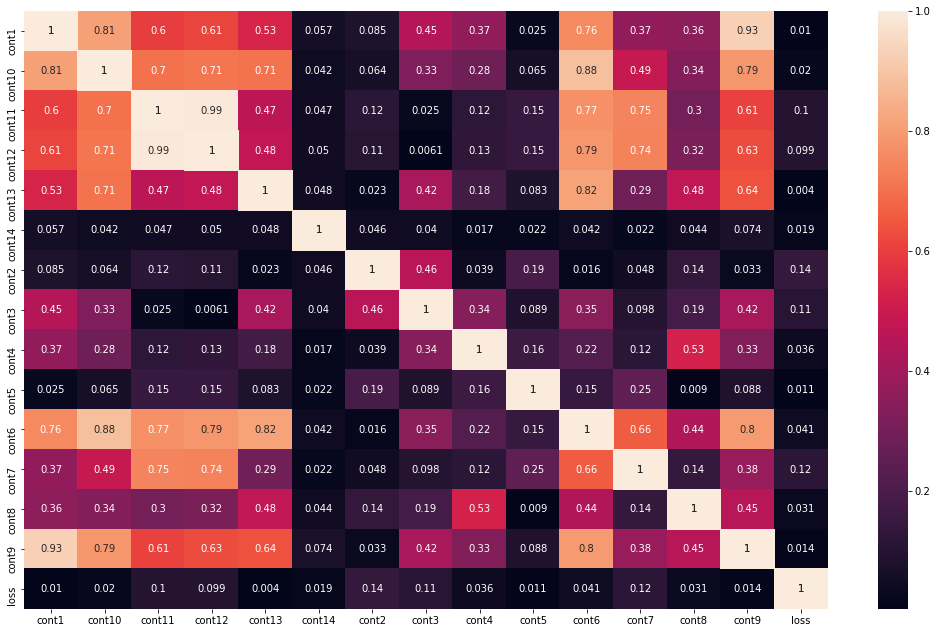

In [34]:
correlationMatrix = df_train[continuous_types].corr().abs()

plt.subplots(figsize=(18, 11))
sns.heatmap(correlationMatrix,annot=True)

# Mask unimportant features
corr_matrix_cont = sns.heatmap(correlationMatrix,
            mask=correlationMatrix < 1,
            cbar=False,
            linecolor='white',
            annot = True)
plt.show()

In [35]:
# save image
corr_matrix_cont.figure.savefig("reports/images/corr_matrix_cont.png")
print(f"Output (corr_matrix_cont) saved.")

Output (corr_matrix_cont) saved.


It`s possible see correlations exists between some of the continuous variables.
In this case, the correlations score between cont10 and cont11 is 0.7. 

### Categorical features

#### Best correlation in categorical feature

In [36]:
corrCatMatrix = data_copy[categorical_types].corr().abs()

s = corrCatMatrix.unstack()
sortedSeries = s.sort_values(kind="quicksort",ascending=False)
best_correlation_categorical = sortedSeries[sortedSeries != 1.0][0:10]

print("Top correlated categorical feature pairs: \n")
print(best_correlation_categorical)

Top correlated categorical feature pairs: 

cat90   cat3      0.956610
cat3    cat90     0.956610
cat89   cat7      0.951530
cat7    cat89     0.951530
cat9    cat2      0.932173
cat2    cat9      0.932173
cat6    cat50     0.926161
cat50   cat6      0.926161
cat116  cat104    0.919646
cat104  cat116    0.919646
dtype: float64


## Prepare Submission File
Use function to submission. In this way it is guaranteed a default.

In [38]:
# First, check how is file sample
sample = pd.read_csv('data_base/sample_submission.csv')
sample.head()

,id,loss
0,4,0
1,6,0
2,9,0
3,12,0
4,15,0


In [39]:
test_ids = df_test['id']

submissions_folder = 'reports/submissions-kaggle/'

In [40]:
def save_predictions(ids = None, predictions = None, file = None):
    
    # prepare file
    submission = pd.DataFrame({'id': ids, 'loss': predictions})
    
    # CSV
    submission.to_csv(path_or_buf = file, index = False, encoding='utf8')
    print("Data storage!")

---

## Split train and test
- The variable Shift is applied to the log transformation.

In [17]:
# split into training and test sets
shift = 200

# create target label
X_train = df_train[continuous_features]
y_train = np.log(df_train['loss'] + shift)

X_test = df_test[continuous_features]

In [18]:
X_train.head()

,cont1,cont10,cont11,cont12,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9
0,0.726300,0.83510,0.569745,0.594646,0.822493,0.714843,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135
1,0.330514,0.43919,0.338312,0.366307,0.611431,0.304496,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127
2,0.261841,0.32446,0.381398,0.373424,0.195709,0.774425,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076
3,0.321594,0.44467,0.327915,0.321570,0.605077,0.602642,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128
4,0.273204,0.21230,0.204687,0.202213,0.246011,0.432606,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089


In [19]:
X_test.head()

,cont1,cont10,cont11,cont12,cont13,cont14,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9
0,0.321594,0.38016,0.377724,0.369858,0.704052,0.392562,0.299102,0.246911,0.402922,0.281143,0.466591,0.317681,0.61229,0.34365
1,0.634734,0.60401,0.689039,0.675759,0.453468,0.208045,0.620805,0.654310,0.946616,0.836443,0.482425,0.443760,0.71330,0.51890
2,0.290813,0.30529,0.245410,0.241676,0.258586,0.297232,0.737068,0.711159,0.412789,0.718531,0.212308,0.325779,0.29758,0.34365
3,0.268622,0.31480,0.348867,0.341872,0.592264,0.555955,0.681761,0.592681,0.354893,0.397069,0.369930,0.342355,0.40028,0.33237
4,0.553846,0.50556,0.359572,0.352251,0.301535,0.825823,0.299102,0.263570,0.696873,0.302678,0.398862,0.391833,0.23688,0.43731


In [20]:
y_train.head()

0    7.788701
1    7.302227
2    8.072495
3    7.038652
4    7.994244
Name: loss, dtype: float64

In [21]:
# check distribuition
print ("Xtrain shape:", X_train.shape[0])
print ("ytrain shape:", X_train.shape[1])
print ("Xtest shape:", X_test.shape[0])
print ("ytest shape:", X_test.shape[1])

Xtrain shape: 188318
ytrain shape: 14
Xtest shape: 125546
ytest shape: 14


## Mean absolute error (MAE) 
- The models in this project use the mean absolute error (MAE) between the predicted loss and the actual loss for each claim in the test set.
- The goal was to minimize the MAE in our model’s predictions. 

In [22]:
# Custom eval metric
def eval_error(preds, dtrain):
    """evaluation"""
    labels = dtrain.get_label()
    return 'mae', mean_absolute_error(np.exp(preds), np.exp(labels))

## K-Folds Cross Validation
KFold divides all the samples in  groups of samples, called folds, of equal sizes (if possible). The prediction function is learned using  folds, and the fold left out is used for test.

In [23]:
# replicate the results
random_state = 16

# folds
k = 5

## Function tranning
- The traning and test it`s in function because garanted reuse.
- The predictions running in validation set in each fold.
- Garanted with array is the inverse of the log transformation about column loss.
- Calculate time
- Calculate MAE

In [24]:
def train_model(model, num_folds):
    """Function by Train model"""
        
    print("Begin training")
    start = time.time()
    
    # declare a KFold instance
    kfold = KFold(n_splits = num_folds, random_state = 10)
    
    # number of models
    num_models = 1
    
    # array to store results after each fold
    results = np.zeros((X_test.shape[0], k))
        
    # train K-1 Random Forests
    for i, (train, val) in enumerate(kfold.split(X_train)):
        # get smaller training set and create validation set
        X_train_mini, X_val = X_train.iloc[train], X_train.iloc[val]
        y_train_mini, y_val = y_train[train], y_train[val]

        # train model
        model.fit(X_train_mini, y_train_mini)

        # make predictions 
        preds = model.predict(X_val)
        
        # absolute error
        error = mean_absolute_error(np.exp(y_val) - shift, np.exp(preds) - shift)
        print("MAE on fold {} is {}".format(i, error))

        
        # Predict on test set
        test_predictions = np.exp(model.predict(X_test)) - shift
        
        # Sum predictions
        results[:,i] = test_predictions
        

    end = time.time()
    print("\nTraining done! Time Elapsed:", end - start, " seconds.")

    # Error over k folds
    avg_error = np.mean(results)

    return test_predictions

## Benchmarks

We will test and execute the models:
- Linear Regression
- Random Forest (Bagging)
- XGBoost

## Linear Regression

In [25]:
# Visualize params
LinearRegression()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [26]:
# Linear Regression
model_lr = LinearRegression(n_jobs=-1, normalize=False)

# training
result_lr = train_model(model = model_lr, num_folds = 5)

Begin training
MAE on fold 0 is 1807.0796683343272
MAE on fold 1 is 1800.4240296635544
MAE on fold 2 is 1813.0442189340124
MAE on fold 3 is 1807.6655531305717
MAE on fold 4 is 1791.136974310215

Training done! Time Elapsed: 0.5454549789428711  seconds.


In [27]:
# Linear Regression normalized
model_lr_normalized = LinearRegression(n_jobs=-1, normalize=True)

# training
result_lr_normalized = train_model(model = model_lr_normalized, num_folds = 5)

Begin training
MAE on fold 0 is 1807.0796683343272
MAE on fold 1 is 1800.4240296635544
MAE on fold 2 is 1813.0442189340124
MAE on fold 3 is 1807.6655531305717
MAE on fold 4 is 1791.1369743102152

Training done! Time Elapsed: 0.558845043182373  seconds.


#### Analysis of Results
- Without difference data normalized and not normalized
- The best result MAE on fold 4 is 1791.1369743102152

#### Submission

In [52]:
save_predictions(ids = test_ids, 
                 predictions = result_lr_normalized, 
                 file = submissions_folder + 'lin_regression_submission.csv')

Data storage!


#### View file

In [53]:
sub = pd.read_csv(submissions_folder + 'lin_regression_submission.csv')
sub.head()

,id,loss
0,4,1931.225538
1,6,2133.298412
2,9,2367.209872
3,12,2360.327366
4,15,1875.892225


## Random Forest

#### Process trainning
- The number of estimators go is tested.
- Update the number of estimators to 20, 50 and 100 to see how the model performs. 

In [54]:
# Visualize params
RandomForestRegressor()

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [55]:
# 1st model Random Forest
rf_regressor_one = RandomForestRegressor(n_estimators = 20, 
                                     n_jobs = -1,
                                     verbose = 1, 
                                     max_depth = 30)

# training
result_rf_1 = train_model(model = rf_regressor_one, num_folds = 5)

Begin training


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


MAE on fold 0 is 1883.11281403666


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.2s finished
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


MAE on fold 1 is 1877.9939685012694


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.9s finished
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


MAE on fold 2 is 1888.9372885481462


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.7s finished
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


MAE on fold 3 is 1884.6849326700649


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    5.6s finished
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.1s finished


MAE on fold 4 is 1883.9210446150428

Training done! Time Elapsed: 31.57465362548828  seconds.


[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.3s finished


In [56]:
# 2st model Random Forest
rf_regressor_two = RandomForestRegressor(n_estimators = 50, 
                                     n_jobs = -1,
                                     verbose = 1, 
                                     max_depth = 30)

# training
result_rf_2 = train_model(model = rf_regressor_two, num_folds = 5)

Begin training


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


MAE on fold 0 is 1862.4591731991095


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


MAE on fold 1 is 1862.187529103901


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.2s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


MAE on fold 2 is 1876.4395481809213


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.9s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


MAE on fold 3 is 1870.0991311193259


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.2s finished


MAE on fold 4 is 1864.870692061006


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.7s finished



Training done! Time Elapsed: 77.98193407058716  seconds.


In [57]:
# 3st model Random Forest
rf_regressor_three = RandomForestRegressor(n_estimators = 100, 
                                     n_jobs = -1,
                                     verbose = 1, 
                                     max_depth = 30)

# training
result_rf_3 = train_model(model = rf_regressor_three, num_folds = 5)

Begin training


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   28.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


MAE on fold 0 is 1857.2348991855777


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   29.8s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


MAE on fold 1 is 1853.5548998464137


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.4s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


MAE on fold 2 is 1867.2710357887624


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.6s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


MAE on fold 3 is 1863.705975533317


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.7s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.4s finished


MAE on fold 4 is 1860.255657233203


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s



Training done! Time Elapsed: 159.49337553977966  seconds.


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.4s finished


#### Analysis of Results
- The increasing the number of estimators improved score.
- The best results produced with n_estimators = 100 on fold 1.
- The best result MAE on fold 1 is 1854.7308563695506
- The problem is time process which grows in the same proportion. 
- The model random forest were worse than linear regression

#### Submission

In [58]:
save_predictions(ids = test_ids, 
                 predictions = result_rf_1, 
                 file = submissions_folder + 'random_forest_submission.csv')

Data storage!


#### View submission

In [59]:
sub = pd.read_csv(submissions_folder + 'random_forest_submission.csv')
sub.head()

,id,loss
0,4,1440.117454
1,6,3515.867221
2,9,2660.891606
3,12,2845.354662
4,15,2065.769031


## XGBoost
- Model very robust
- descentent gradient 
- regularization parameter: help avoid overfitting
- parallelizable

The model XGBRegressor will be trained with threee model using difference parameters.

#### Otimize XGBoost

DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.

In [28]:
# Data Matrix used in XGBoost.
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

#### Function  train_test_xgboost
- The function process data to:
 - calculate time process
 - shuffle the data during each fold
 - run predictions
 - store these predictions in a numpy array
 - average the predictions over k number of folds.

In [29]:
def train_test_xgboost(model, early_stopping_rounds):
    kf = KFold(n_splits = k, shuffle = True, random_state = random_state)
    results = np.zeros((X_test.shape[0], k))
    
    print("Begin training")
    start = time.time()
    
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print("Begin training and testing base model on fold {}".format(i))
        start = time.time()
        
        X_train_mini, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_mini, y_val = y_train[train_index], y_train[val_index]

        # train model
        model.fit(X_train_mini, 
                   y_train_mini, 
                   eval_metric = eval_error, 
                   eval_set = [(X_train_mini, y_train_mini), (X_val, y_val)], 
                   early_stopping_rounds = early_stopping_rounds,
                   verbose = False)

        end = time.time()
        print("Training time elapsed on fold {} is {}".format(i, end - start))
        
        # Predict on validation set 
        val_predictions = model.predict(X_val, ntree_limit = model.best_ntree_limit)
        error = mean_absolute_error(np.exp(y_val) - shift, np.exp(val_predictions) - shift)
        print("Error on fold {} is {} \n".format(i, error))
                
        # Predict on test set
        test_predictions = np.exp(model.predict(X_test, ntree_limit = model.best_ntree_limit)) - shift
        # Sum predictions
        results[:,i] = test_predictions
        
        end = time.time()
        print("\nTraining done! Time Elapsed:", end - start, " seconds.")

    # Average predictions
    mean_results = results.mean(axis = 1)
    return mean_results

In [30]:
# Visualize params
XGBRegressor()

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

#### Chooce parameters
It´s possible reduce error and overfitting with analysis of parameters. Here is a list of the key parameters below:

- max_depth - Max tree depth for boosted trees
- gamma - Minimum loss reduction required to make a further partition on a leaf node of the tree.
- min_child_weight - Minimum sum of instance weight(hessian) needed in a child.

**NOTE**: keep someone parameters default, how by example, learning_rate=0.1.<br/>
**NOTE about n_estimators**: when tested there aren´t effect

In [31]:
# Model 1 XGB_regressor
xgb_one = XGBRegressor(learning_rate=0.1,
                   n_estimators = 1000,
                   max_depth = 7,
                   min_child_weight = 5.0,
                   gamma = 0.0,
                   subsample = 1.0,
                   colsample_bytree = 1.0,
                   reg_alpha = 1.0,
                   silent = True, 
                   seed = random_state, 
                   nthread = -1)

# training
results_xgb_1 = train_test_xgboost(model = xgb_one, early_stopping_rounds = 50)

Begin training
Begin training and testing base model on fold 0
Training time elapsed on fold 0 is 5.381052732467651
Error on fold 0 is 1754.9950149950985 


Training done! Time Elapsed: 5.4818274974823  seconds.
Begin training and testing base model on fold 1
Training time elapsed on fold 1 is 5.354362726211548
Error on fold 1 is 1756.4265321224348 


Training done! Time Elapsed: 5.447749614715576  seconds.
Begin training and testing base model on fold 2
Training time elapsed on fold 2 is 5.653795480728149
Error on fold 2 is 1759.2237062050713 


Training done! Time Elapsed: 5.754266738891602  seconds.
Begin training and testing base model on fold 3
Training time elapsed on fold 3 is 6.929504156112671
Error on fold 3 is 1781.6322671413254 


Training done! Time Elapsed: 7.030604839324951  seconds.
Begin training and testing base model on fold 4
Training time elapsed on fold 4 is 5.493139743804932
Error on fold 4 is 1777.8328057889364 


Training done! Time Elapsed: 5.5889129638671875  

In [32]:
# Model 2 XGB_regressor
xgb_two = XGBRegressor(learning_rate=0.1,
                   n_estimators = 1000,
                   max_depth = 5,
                   min_child_weight = 6.0,
                   gamma = 1,
                   subsample = 1.0,
                   colsample_bytree = 1.0,
                   reg_alpha = 1.0,
                   silent = True, 
                   seed = random_state, 
                   nthread = -1)
# training
results_xgb_2 = train_test_xgboost(model = xgb_two, early_stopping_rounds = 50)

Begin training
Begin training and testing base model on fold 0
Training time elapsed on fold 0 is 17.24937868118286
Error on fold 0 is 1753.781539347413 


Training done! Time Elapsed: 17.64673161506653  seconds.
Begin training and testing base model on fold 1
Training time elapsed on fold 1 is 9.64679217338562
Error on fold 1 is 1756.6765515914565 


Training done! Time Elapsed: 9.853312730789185  seconds.
Begin training and testing base model on fold 2
Training time elapsed on fold 2 is 12.05475926399231
Error on fold 2 is 1759.8236802935864 


Training done! Time Elapsed: 12.372527599334717  seconds.
Begin training and testing base model on fold 3
Training time elapsed on fold 3 is 10.725663661956787
Error on fold 3 is 1780.2660530561793 


Training done! Time Elapsed: 11.047151327133179  seconds.
Begin training and testing base model on fold 4
Training time elapsed on fold 4 is 8.253528833389282
Error on fold 4 is 1778.7521190385949 


Training done! Time Elapsed: 8.462790489196777

In [33]:
# Model 3 XGB_regressor
xgb_three = XGBRegressor(learning_rate=0.1,
                   n_estimators = 1000,
                   max_depth = 9,
                   min_child_weight = 6,
                   gamma = 1,
                   subsample = 1.0,
                   colsample_bytree = 0.5,
                   reg_alpha = 1.0,
                   silent = True, 
                   seed = random_state, 
                   nthread = -1)

# training
results_xgb_3 = train_test_xgboost(model = xgb_three, early_stopping_rounds = 50)

Begin training
Begin training and testing base model on fold 0
Training time elapsed on fold 0 is 5.213231325149536
Error on fold 0 is 1753.6550894377651 


Training done! Time Elapsed: 5.380172967910767  seconds.
Begin training and testing base model on fold 1
Training time elapsed on fold 1 is 5.120274782180786
Error on fold 1 is 1755.643903900574 


Training done! Time Elapsed: 5.253055095672607  seconds.
Begin training and testing base model on fold 2
Training time elapsed on fold 2 is 5.862375497817993
Error on fold 2 is 1758.7314403686264 


Training done! Time Elapsed: 6.005378484725952  seconds.
Begin training and testing base model on fold 3
Training time elapsed on fold 3 is 10.523555994033813
Error on fold 3 is 1780.1834400402604 


Training done! Time Elapsed: 10.8816397190094  seconds.
Begin training and testing base model on fold 4
Training time elapsed on fold 4 is 4.899635314941406
Error on fold 4 is 1777.4129652136787 


Training done! Time Elapsed: 5.021101236343384  

#### Submission

In [66]:
save_predictions(ids = test_ids, 
                 predictions = results_xgb_1, 
                 file = submissions_folder + 'xgb_submission.csv')

Data storage!


#### View submission

In [67]:
sub = pd.read_csv(submissions_folder + 'xgb_submission.csv')
sub.head()

,id,loss
0,4,1898.224316
1,6,2694.506299
2,9,2250.072803
3,12,2243.946582
4,15,1953.832666


#### Analysis of Results
- The XGBoost have better performace in comparain Random Forest and Linear Regression
- The best result MAE on fold 0 is 1753.6550894377651 in three model
- I tested parameters difference in each model XGBoost
- So, I chooce file xgb_submission to submission in competition.